In [1]:
#webscraping and global freq weights to find significant alleles


import requests
import bs4
import sys
# !conda install --yes --prefix {sys.prefix} lxml
import csv
import matplotlib.pyplot as plt

import fnmatch
import os
import numpy as np
import pandas as pd
import scipy.stats as ss
import seaborn as sns

%matplotlib inline


### Class: Locus - Scrape and choose alleles and their frequencies

In [2]:

class locus:
    """
    Loci: A, B, C, DPA1, DPB1, DQA1, DQB1, DRB1
    
    Field variables:
    
    type: 0 (mhc1), 3 (mhc2)
    
    sortedAlleles
    sortedAvgFreqs
    
    cummAvgFreqs
    numberOfAllelesWithNoFrequencies
    
    alleles = alleles as list
    string = alleles as string
    
    *open
    
    Files: (for X named locus)
    * X (directory)
        * X_alleles = all alleles with freq (sorted)
        * X_alleles_thr = alleles above thr with freq (sorted)
    
    
    link
    
    """
    
    
    
    def __init__(self,name, makePlot = False, p=0.95):
        """
        Parameters:
            name = locus name
            makePlot = if true: webscrapes and make plot and sets new values
                        otw: takes data from existing files
        
        """
        self.regionsDensities = [0.0033, 0.0959, 0.0316, 0.0473, 0.2153, 0.0055, 0.0784, 0.2489, 0.0858, 0.1404, 0.0359]
        self.regionsN = ['Australia', 'Europe', 'North%20Africa', 'North%20America', 'North-East%20Asia', 'Oceania', 'South%20and%20Central%20America', 'South%20Asia', 'South-East%20Asia','Sub-Saharan%20Africa','Western%20Asia']
    
        self.name=name
        self.type=0 #mhc1
        if name[0]=='D':
            self.type=3 #mhc2
        self.alleles = {''}
        self.numberOfAllelesWithNoFrequencies=0
        if makePlot: 
            if not (os.path.isdir(self.name)):
                os.mkdir(self.name)
            self.makeAlleleFreqs(p)
        else:
            self.getSortedData(p)

    
    def getDict(self,region):
        self.link='http://allelefrequencies.net/hla6006a_scr.asp?hla_locus='+self.name+'&hla_locus_type=Classical&hla_allele1=&hla_allele2=&hla_selection=&hla_pop_selection=&hla_population=&hla_country=&hla_dataset=&hla_region='+region+'&hla_ethnic=&hla_study=&hla_sample_size=&hla_sample_size_pattern=equal&hla_sample_year=&hla_sample_year_pattern=equal&hla_level=&hla_level_pattern=equal&hla_show=&hla_order=order_1&standard=a'
        allfreqsDict={}
        freqs=[]
        res = requests.get(self.link)
        tabl = bs4.BeautifulSoup(res.text, 'lxml')
        
        allelesTags = tabl.select('#divGenDetail td:nth-child(2)')
        freqsTags = tabl.select('#divGenDetail td:nth-child(5)')
        


        for n in range(len(allelesTags)):
            allele = allelesTags[n].getText()
            
            if len(allele)>=7+self.type and allele[-1] != 'Q' and allele[-1] != 'N': #checking usability
                if  len(allele)>7+self.type and allele[7+self.type]!=':':#alleles like A*11:140 or DPA1*02:101
                    allele=(allele[:8+self.type])
                else:
                    allele=(allele[:7+self.type])
                #we have the allele, checking if it's same as prev
                
            
                if allele in allfreqsDict:
                    
                    if freqsTags[n].getText() != '' and float(freqsTags[n].getText()) != 0.0:
                        allfreqsDict[allele].append(float(freqsTags[n].getText()))
                else:
                    
                    if freqsTags[n].getText() == '':
                        self.numberOfAllelesWithNoFrequencies+=1
                    elif float(freqsTags[n].getText()) != 0.0:
                        allfreqsDict[allele]=[float(freqsTags[n].getText())]                
        return allfreqsDict
        
    def make(self):
        dicts = []
        if '' in self.alleles:
            self.alleles.remove('')
        for region in self.regionsN:
            print("Searching %s..." % region)
            dictForRegion =self.getDict(region)
            dicts.append(dictForRegion)
            
            for allele in dictForRegion.keys():
                self.alleles.add(allele)
        return dicts
       
    def makecsv(self):
        
        self.csvName = self.name+"/"+self.name + '*.csv'
        self.freqs=[]

        with open(self.csvName,'w',newline='') as file:
            writer = csv.writer(file)
            
            dicts = self.make()
            self.listAlleles = sorted(self.alleles)
            listAlleles = self.listAlleles
            writer.writerow(['Region']+  listAlleles)
               
            for i in range(len(dicts)):
                regionDict = dicts[i]

                row=[]
                row.append(self.regionsN[i])
                
                iAlleleInDict = 0
                iAlleleInAlleles = 0
                allelesInRegion = list(sorted(regionDict.keys()))
                
                while iAlleleInAlleles < len(listAlleles):
                    
                    if iAlleleInDict < len(allelesInRegion) and allelesInRegion[iAlleleInDict] == listAlleles[iAlleleInAlleles]:
                        listFreqs = regionDict.get(allelesInRegion[iAlleleInDict])
                        sumFreqs = sum(listFreqs)
                        
                        average= sumFreqs/len(listFreqs)
                        row.append(average)
                        if iAlleleInDict < len(allelesInRegion)-1:
                            iAlleleInDict +=1
                    else:
                        row.append(0.0)
                    
                    iAlleleInAlleles+=1
                writer.writerow(row)
                row.pop(0)
                self.freqs.append(row)
    
    
    def makeAlleleFreqs(self, p):
        
        
        
        
        
        
        self.makecsv()
        self.avgFreqs=[]
        #uncomment to ignore population factor
        #self.regionsDensities = [1]*len(self.regionsDensities)

        for i in range(len(self.alleles)):
            sumFreqs=0.0
    
            for iRegion in range(len(self.freqs)):
                
                regionRow=self.freqs[iRegion]
                regionDensity=self.regionsDensities[iRegion]
                
                freq = regionRow[i]*regionDensity
                sumFreqs+=freq
        
        
            self.avgFreqs.append(float(sumFreqs/sum(self.regionsDensities)))
            
##################

        d = {"alleles":list(self.listAlleles), "avgFreqs":list(self.avgFreqs)}
        df = pd.DataFrame(data = d)
        df = df.sort_values(by=['avgFreqs'],ascending = False)
        df.to_csv(self.name+"/"+self.name+"_alleles.csv", index = False)
        self.sortedAlleles=np.array(list(df['alleles']))
        self.sortedAvgFreqs=np.array(list(df['avgFreqs']))
        self.thresholdGraph(p)

    def thresholdGraph(self, p):
        print("threshold :",p)
        self.cummAvgFreqs = np.cumsum(self.sortedAvgFreqs)
        cummFreq = np.sum(self.sortedAvgFreqs)

        # get index for cutoff
        i=0
        # taking first first p cutoff alleles
        while self.cummAvgFreqs[i] < cummFreq*(p):
            i+=1
##################

        print("Taking first %d alleles by freq" % i)
        self.tsortedAvgFreqs = self.sortedAvgFreqs[:i]
        self.tsortedAlleles = self.sortedAlleles[:i]
        print("cummFreq, cummFreq*(p) : ",cummFreq, cummFreq*(p))
        print("sum n len after",sum(self.tsortedAvgFreqs),len(self.tsortedAvgFreqs))

        
        plt.plot(self.tsortedAvgFreqs,color='blue', marker='o', linestyle='dashed',linewidth=2, markersize=4)
        plt.plot([cummFreq*(p)-self.cummAvgFreqs[i-1]]*len(self.sortedAlleles),color='purple', marker='o', linestyle='dashed',linewidth=2, markersize=4)
        plt.xlabel("sorted alleles")
        plt.ylabel("agg. frequencies")

        print("Populationwise Allele freqs sored in: ", self.csvName)
#***************

        d = {"alleles":list(self.tsortedAlleles), "avgFreqs":list(self.tsortedAvgFreqs)}
        df = pd.DataFrame(data = d)
        df.to_csv(self.name+"/"+self.name+"_alleles_thr.csv", index = False)
#***************
        
        self.string = ""
        
    def makeString(self, m, first=True):
        self.string=""
        dir = 1
        if not first:
            dir = -1
        for allele in self.sortedAlleles[:m:dir]:
            self.string += "HLA-"+allele[0] + allele[2:] + ","
    
        self.string = self.string[:-1]
        return self.string
        
    def makeAllelesFile(self):
        pd.Series(["HLA-"+allele[:self.type+1] + allele[self.type+2:] for allele in list(self.sortedAlleles)]).to_csv(self.name+"/"+self.name+"alleles.txt", sep="\n",index = False, header=False)
    
    def getSortedData(self, p):
        self.csvName = self.name+"/"+self.name + '*.csv'
        df = pd.read_csv(self.name+"/"+self.name+"_alleles.csv")
        self.sortedAlleles = np.array(df["alleles"])
        self.sortedAvgFreqs = np.array(df["avgFreqs"])
        self.thresholdGraph(p)

#### Making B locus

threshold : 0.98
Taking first 5 alleles by freq
cummFreq, cummFreq*(p) :  0.798659255809963 0.7826860706937637
sum n len after 0.777550462258747 5
Populationwise Allele freqs sored in:  DPA1/DPA1*.csv


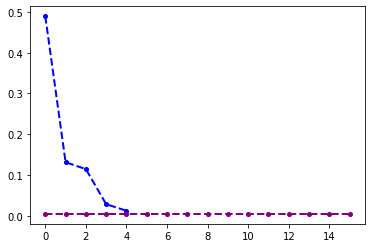

In [37]:
DPA1=locus('DPA1',False, 0.98)
# B=locus('B', False)


In [38]:
# DPA1.makeAllelesFile()



In [19]:
DPA1.sortedAvgFreqs

array([4.89173580e-01, 1.31716244e-01, 1.14840448e-01, 2.89538298e-02,
       1.28663594e-02, 1.24438167e-02, 1.95823131e-03, 1.64960032e-03,
       1.64798138e-03, 1.42902965e-03, 1.06646767e-03, 5.14627812e-04,
       2.44885156e-04, 8.90417889e-05, 5.64302337e-05, 8.68157442e-06])

In [304]:
# self = A

# pd.Series(["HLA-"+allele[0] + allele[2:] for allele in list(self.sortedAlleles)]).to_csv(self.name+"/"+self.name+"alleles.txt", sep="\n",index = False, header=False)

In [39]:
!ls A/xlsFiles | wc -l


     203


In [40]:
list(A.sortedAlleles).index("A*31:05")

NameError: name 'A' is not defined

In [303]:
import unittest
allele1 = "A*32:04"
pos = 369
idx = A.listAlleles.index(allele1)

assert idx == pos

allele1freqs= (np.array(A.freqs))[:,idx]

np.dot(allele1freqs,(np.array(A.regionsDensities)))/sum(A.regionsDensities)

assert A.sortedAlleles[list(A.sortedAvgFreqs).index(0.00410018466052818)] == allele1


threshold : 0.95
Taking first 209 alleles by freq
cummFreq, cummFreq*(p) :  2.090893750675141 1.9863490631413838
sum n len after 1.9852913818380933 209
Populationwise Allele freqs sored in:  B/B*.csv


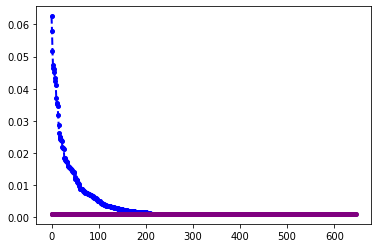

In [42]:
B=locus('B')

threshold : 0.95
Taking first 125 alleles by freq
cummFreq, cummFreq*(p) :  1.6400391545903985 1.5580371968608786
sum n len after 1.5574532310168963 125
Populationwise Allele freqs sored in:  A/A*.csv


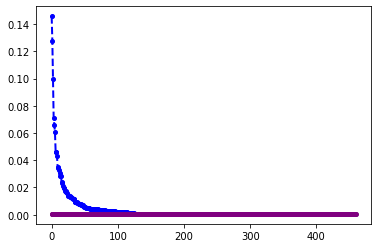

In [61]:
A=locus('A')

In [196]:
allele ="HLA-A0101"
df = pd.read_csv("A/xlsFiles/"+allele+"_many.xls", sep = '\t', header =1, index_col = 1)
print(len(df["ID"]))
df.loc[df.loc[df['NB']==1].index]

18564


,Pos,ID,core,icore,EL-score,EL_Rank,Ave,NB
Peptide,,,,,,,,
KVHHANENIFY,19,AAB59956_1_oval,KVANENIFY,KVHHANENIFY,0.0857,1.4951,0.0857,1
KVHHANENIFY,19,AAC16664_1_oval,KVANENIFY,KVHHANENIFY,0.0857,1.4951,0.0857,1
VYSFSLASRLY,96,AAB59956_1_oval,YSFSASRLY,YSFSLASRLY,0.0649,1.7832,0.0649,1
VYSFSLASRLY,96,AAC16664_1_oval,YSFSASRLY,YSFSLASRLY,0.0649,1.7832,0.0649,1
EQESKPVQMMY,202,AAB59956_1_oval,EQEPVQMMY,EQESKPVQMMY,0.4244,0.3929,0.4244,1
...,...,...,...,...,...,...,...,...
LQAMHREKY,115,NP_003131_1_sex,LQAMHREKY,LQAMHREKY,0.1496,1.0124,0.1496,1
REKYPNYKY,120,NP_003131_1_sex,REKYPNYKY,REKYPNYKY,0.0683,1.7333,0.0683,1
EVQLDNRLY,155,NP_003131_1_sex,EVQLDNRLY,EVQLDNRLY,0.3361,0.5114,0.3361,1


# A epitopes analysis first 225 alleles


threshold : 0.95
Taking first 125 alleles by freq
cummFreq, cummFreq*(p) :  1.6400391545903985 1.5580371968608786
sum n len after 1.5574532310168963 125
Populationwise Allele freqs sored in:  A/A*.csv


(18564, 461)

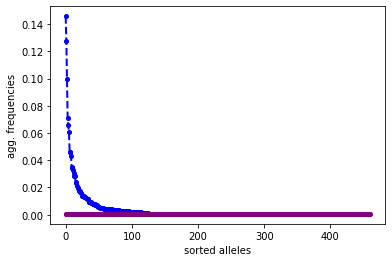

In [3]:
loc = None
loc=locus('A')

def xlsname(allele):
    return loc.name+"/xlsFiles/"+"HLA-"+allele[:loc.type+1] + allele[loc.type+2:loc.type+4]+ allele[loc.type+5:]+"_many.xls"
def getCSV(allele):
    return pd.read_csv(xlsname(allele), sep = '\t', header =1, index_col = 'Peptide')
def ELR(allele):
    df = getCSV(allele)
    return np.array(df['EL_Rank'])
def NB(allele):
    df = getCSV(allele)
    return np.array(df['NB'])

xlsdir=loc.name+"/xlsFiles"
dirs,files = os.walk(xlsdir)
noAlleles= len(dirs[2])
tAll = loc.sortedAlleles[:noAlleles]
tFreq= loc.sortedAvgFreqs[:noAlleles]

#Reference fo repitopes and IDs
samplecsv = getCSV(tAll[0])
Epitopes = samplecsv.index
IDs= samplecsv['ID']

Epitopes=np.array(Epitopes)
DF_ranks = pd.DataFrame(index = Epitopes)
DF_NBs = pd.DataFrame(index = Epitopes)

i = 0
for allele in tAll:
#     df = pd.read_csv(xlsname(allele), sep = '\t', header =1)
    DF_ranks.insert(i, allele, ELR(allele))
    DF_NBs.insert(i, allele, NB(allele))
    i+=1

#EL_ranks
aveRanks = np.average(np.array(DF_ranks), axis = 1)
aggRanks = np.average(DF_ranks, axis = 1, weights = tFreq)
randRanks = np.average(DF_ranks, axis = 1, weights = np.absolute(np.random.randn(DF_ranks.shape[1])))

#NB
NBs=np.sum(DF_NBs, axis = 1, keepdims = False)
DF_ranks.shape


In [4]:
# taking binders only
Binding_peptides=NBs[NBs>0].index
DF_ranks.loc[Binding_peptides]

,A*24:02,A*02:01,A*11:01,A*01:01,A*33:03,A*03:01,A*31:01,A*02:06,A*26:01,A*31:08,...,A*23:29,A*32:21,A*68:55,A*03:09,A*03:19,A*31:27,A*36:05,A*29:05,A*01:86,A*02:434
ASMEFCFDVFK,28.0000,43.5714,0.3058,17.9677,10.2151,1.8177,4.3011,38.6154,27.7727,27.4130,...,25.2500,17.0484,3.4925,1.9474,15.7966,4.3011,14.8665,32.6471,17.9677,43.5714
DVFKELKVHHA,39.3333,14.9968,43.0000,34.7143,8.5652,38.5000,17.0450,12.8468,6.1440,45.2857,...,42.5000,42.6667,9.6425,41.6667,28.3810,17.0450,52.0253,36.3333,34.7143,14.9968
DVFKELKVHHA,39.3333,14.9968,43.0000,34.7143,8.5652,38.5000,17.0450,12.8468,6.1440,45.2857,...,42.5000,42.6667,9.6425,41.6667,28.3810,17.0450,52.0253,36.3333,34.7143,14.9968
KVHHANENIFY,11.6730,26.5946,2.1561,1.4951,18.0330,2.2851,5.6255,26.4556,3.5355,3.3628,...,11.7619,1.4288,8.8976,2.2792,12.9309,5.6255,0.5007,1.1808,1.4951,26.5946
KVHHANENIFY,11.6730,26.5946,2.1561,1.4951,18.0330,2.2851,5.6255,26.4556,3.5355,3.3628,...,11.7619,1.4288,8.8976,2.2792,12.9309,5.6255,0.5007,1.1808,1.4951,26.5946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RKAKMLPK,60.0000,77.5000,13.7755,77.9167,30.8649,6.9609,7.9279,80.8333,67.5000,42.8889,...,60.0000,41.6000,34.6429,9.7296,46.0000,7.9279,62.7907,47.5000,77.9167,77.5000
VQLDNRLY,15.1039,37.8182,12.1543,4.8448,24.8026,14.6796,21.4783,28.0972,10.0905,5.2040,...,12.0492,11.4712,26.3250,12.3938,41.1667,21.4783,4.9509,1.9820,4.8448,37.8182
QLDNRLYR,34.0000,25.8500,7.2491,8.6794,2.4721,6.1694,3.2043,42.8333,33.6364,33.4545,...,38.5000,31.9412,8.4495,5.6734,30.7647,3.2043,6.5750,14.8641,8.6794,25.8500
CTKATHSR,44.5000,63.3333,8.1238,43.9167,1.7220,11.5981,2.1255,61.2500,28.3158,37.7857,...,55.0000,39.7143,3.5809,13.6484,32.2667,2.1255,25.6742,36.5833,43.9167,63.3333


In [5]:
IDs

Peptide
MGSIGAASMEF    AAB59956_1_oval
GSIGAASMEFC    AAB59956_1_oval
SIGAASMEFCF    AAB59956_1_oval
IGAASMEFCFD    AAB59956_1_oval
GAASMEFCFDV    AAB59956_1_oval
                    ...       
QQRDRYSH       NP_003131_1_sex
QRDRYSHW       NP_003131_1_sex
RDRYSHWT       NP_003131_1_sex
DRYSHWTK       NP_003131_1_sex
RYSHWTKL       NP_003131_1_sex
Name: ID, Length: 18564, dtype: object

In [6]:
# ### Mean Normaliztion od aggRanks2 and aveRanks
# aveRanksNorm = aveRanks - np.sum(DF_ranks, axis = 1)/noAlleles
# aveRanks, aveRanksNorm, np.sum(DF_ranks, axis = 1)/noAlleles

In [7]:
import scipy.stats as ss
# nbe = nbe.tolist()
# aggRanks = aggRanks.tolist()
# print(nbe.dtype)
print(aggRanks.dtype)

# print(nbe.shape)
print(aggRanks.shape)
print("freqs weighted by rands")
print(ss.spearmanr(randRanks,aggRanks))
print("freqs weighted by global freq")
print(ss.spearmanr(aggRanks,NBs))
print("ave freqs")
print(ss.spearmanr(aveRanks,NBs))
print("ave/agg freqs")
print(ss.pearsonr(aveRanks.squeeze(),aggRanks.squeeze()))
print("Min aggRank: ",DF_ranks.index[list(aggRanks).index(np.min(aggRanks))], NBs[list(aggRanks).index(np.min(aggRanks))],np.min(aggRanks), np.min(aveRanks))
print("Max aggRank: ",DF_ranks.index[list(aggRanks).index(np.max(aggRanks))], NBs[list(aggRanks).index(np.max(aggRanks))],np.max(aggRanks), np.max(aveRanks))

float64
(18564,)
freqs weighted by rands
SpearmanrResult(correlation=0.9974081262606836, pvalue=0.0)
freqs weighted by global freq
SpearmanrResult(correlation=-0.6696106371964178, pvalue=0.0)
ave freqs
SpearmanrResult(correlation=-0.675950195120268, pvalue=0.0)
ave/agg freqs
(0.999041098456778, 0.0)
Min aggRank:  SQMEKVLHL 336 1.3794294833279845 1.363476138828636
Max aggRank:  GKVCNPDN 0 99.97061010847032 99.9546726681128


aggRanks and aveRanks are still highly coorrelated

0.07626562381249957
0.0035575686650550944
-0.0035539361648021348
0.14231498110273744


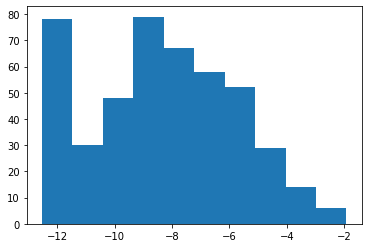

In [8]:
# z scores and outliers
std_tFreq = ss.zscore(tFreq)
# for i in range(len(std_tFreq)):
#     if std_tFreq[i] > 3 or std_tFreq[i] < -3:
#         print(alleles[i], std_tFreq[i] )
#print(std_tFreq)

#plt.hist(std_tFreq)
#plt.hist(tFreq)
#plt.pl(std_tFreq)

logtFreq=np.log(tFreq)
plt.hist(logtFreq)

print(ss.tstd(tFreq)*6)
print(np.mean(tFreq))
print(np.min(tFreq)-np.mean(tFreq))
print(np.max(tFreq)-np.mean(tFreq))

In [9]:
# comparing epitope profile of A*26:04 and A*26:20
print(
ss.pearsonr(np.array(DF_ranks['A*26:04']),np.array(DF_ranks['A*26:01'])),
ss.pearsonr(np.array(DF_ranks['A*26:20']),np.array(DF_ranks['A*26:01'])),
ss.pearsonr(np.array(DF_ranks['A*26:04']),np.array(DF_ranks['A*03:01']))
)


(0.979998039437568, 0.0) (0.9790915684116315, 0.0) (0.6992919973639957, 0.0)


# UMAP Analysis of HLA by epitope profile



In [10]:
# taking the ranks matrix as high dimensional input
# epitopes = Epitopes[]
ranks=DF_ranks.loc[NBs[NBs>0].index].T.values


In [11]:
ranks.shape

(461, 4896)

In [12]:
from sklearn.preprocessing import StandardScaler
import umap
reducer = umap.UMAP()

# scaled_ranks = StandardScaler().fit_transform(ranks)
embedding = reducer.fit_transform(ranks)
embedding.shape

(461, 2)

In [13]:
# from sklearn.neighbors import NearestNeighbors
# nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(X)

In [14]:
#set color map
color_map={}


In [15]:
subtypes= DF_ranks.columns
types = [int(x[2:4]) for x in subtypes]
len(types)

461

In [16]:
max(types)

80

In [1]:
# from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
# init_notebook_mode(connected=True)
# import cufflinks as cf
# cf.go_offline()

dfUMAP = pd.DataFrame()
dfUMAP['allele']=DF_ranks.columns
dfUMAP['type']=types
dfUMAP['0']=embedding[:,0]
dfUMAP['1']=embedding[:,1]

import plotly.express as px
import plotly.graph_objects as go

# fig = px.scatter(df, x='0', y='1', color="allele", hover_data=['allele'])
fig = go.Figure(data=go.Scatter(x=dfUMAP['0'],
                                y=dfUMAP['1'],
                                mode='markers',
                                marker_color=dfUMAP['type'],
                                text=dfUMAP['allele'])) # hover text goes here
fig.update_layout(
    autosize=False,
    width=1000,
    height=1000,)
fig.show()

NameError: name 'pd' is not defined

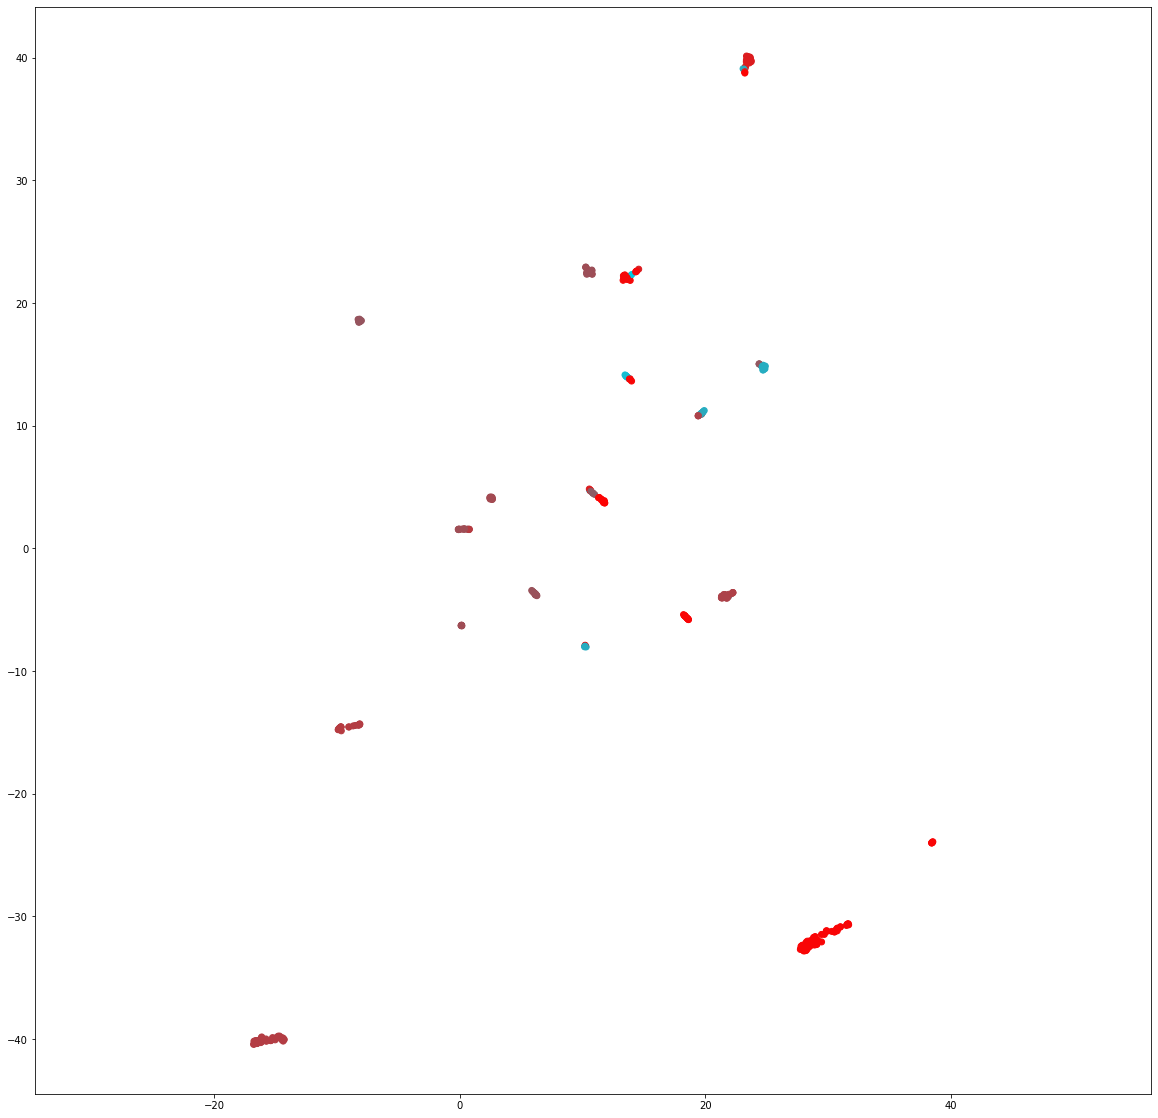

In [17]:
# plt.figure(figsize=(20,20))

# plt.scatter(
#     embedding[:, 0],
#     embedding[:, 1],
#     c=[[1-x/80,(x/100),(x/90)] for x in types])


# # #A*3 alleles
# # idx01 = list(DF_ranks.columns).index('A*03:01')
# # idx02 = list(DF_ranks.columns).index('A*03:02')
# # idx18 = list(DF_ranks.columns).index('A*03:18')
# # idx103 = list(DF_ranks.columns).index('A*03:103')
# # plt.annotate("A*03:01",(embedding[idx01, 0],embedding[idx01, 1]))
# # plt.annotate("A*03:02",(embedding[idx02, 0],embedding[idx02, 1]), ha="center")
# # plt.annotate("A*03:18",(embedding[idx18, 0],embedding[idx18, 1]), ha="left")
# # plt.annotate("A*03:103",(embedding[idx103, 0],embedding[idx103, 1]), ha="right")

# # #A*2 alleles
# # idx01 = list(DF_ranks.columns).index('A*02:01')
# # idx02 = list(DF_ranks.columns).index('A*02:02')
# # idx18 = list(DF_ranks.columns).index('A*02:18')
# # idx103 = list(DF_ranks.columns).index('A*03:103')
# # plt.annotate("A*02:01",(embedding[idx01, 0],embedding[idx01, 1]))
# # plt.annotate("A*02:103",(embedding[idx103, 0],embedding[idx103, 1]), ha="right")# in A*3 crowd
# # plt.annotate("A*02:02",(embedding[idx02, 0],embedding[idx02, 1]), ha="center")
# # plt.annotate("A*02:18",(embedding[idx18, 0],embedding[idx18, 1]), ha="left")


# # #A*26 alleles
# # idx01 = list(DF_ranks.columns).index('A*26:01')
# # idx04 = list(DF_ranks.columns).index('A*26:04')
# # idx20 = list(DF_ranks.columns).index('A*26:20')
# # plt.annotate("A*26:01",(embedding[idx01, 0],embedding[idx01, 1]))
# # plt.annotate("A*26:04",(embedding[idx04, 0],embedding[idx04, 1]), ha="center")
# # plt.annotate("A*26:20",(embedding[idx20, 0],embedding[idx20, 1]), ha="left")
# # plt.show()
# plt.gca().set_aspect('equal','datalim')



In [33]:
!jupyter labextension install jupyterlab-plotly@4.12.0

Building jupyterlab assets (build:prod:minimize)
An error occured.
RuntimeError: npm dependencies failed to install
See the log file for details:  /var/folders/2k/dj86bmd13c568t37244vhbbh0000gn/T/jupyterlab-debug-uxq_51rj.log


,allele,type,0,1
0,A*24:02,24,-16.485695,-40.162384
1,A*02:01,2,27.749077,-32.687756
2,A*11:01,11,23.420238,40.022045
3,A*01:01,1,11.810868,3.698692
4,A*33:03,33,-8.024852,18.557989
...,...,...,...,...
456,A*31:27,31,10.471105,22.441933
457,A*36:05,36,10.849241,4.479274
458,A*29:05,29,2.544406,4.075929
459,A*01:86,1,11.709561,3.757082


In [2]:
# !jupyter lab build


[LabBuildApp] JupyterLab 1.1.4
[LabBuildApp] Building in /Users/ishaangupta/opt/anaconda3/share/jupyter/lab
[LabBuildApp] Building jupyterlab assets (build:prod:minimize)
An error occured.
RuntimeError: npm dependencies failed to install
See the log file for details:  /var/folders/2k/dj86bmd13c568t37244vhbbh0000gn/T/jupyterlab-debug-we783cxu.log


In [32]:
np.array(sns.color_palette(n_colors=99)).shape

(99, 3)

In [165]:
# # get allele-wise ranks and aggRanks2 - numpy implementation
# import fnmatch
# import os
# import time
# import numpy as np
# import pandas as pd

# # ranks
# # ranks_agg_alleles


# nFiles = 0

# alleles = []
# header = []

# testRanksA =[]
# testAllele = 'A*01:01' #we use the index to match test allele with nba sum

# testEpitopeIdx1 = 1
# testEpitopeCount1 = 0

# testEpitopeIdx2 = 4
# testEpitopeCount2 = 0

# ranks = np.array([])
# nbs = np.array([], dtype = float)

# allfreqs = np.array([])
# tik = time.time()
# #iterating over allele-specific files
# for file in os.listdir('A/xlsFiles'):
#     if file == ".ipynb_checkpoints":
#         continue
#     path = 'A/xlsFiles/'+file
#     fileOpen = open(path)


#     #getting allele name
#     allele=file[4]+"*"+file[5:7]+":"+file[7:-9]

#     #checking for errors
#     if(allele not in A.sortedAlleles):
#         #in case of an allele not found error message at the end
#         print("ERROR: could not find in soretedAlleles "+allele)
#         continue
    
#     #valid file
#     nFiles+=1
#     #getting correspinding global frequency
#     allfreq=(A.sortedAvgFreqs[list(A.sortedAlleles).index(allele)])
    
#     alleleResults = pd.read_csv(path, sep='\t', header = 1)
    
#     try:
#         if(len(alleleResults["EL_Rank"]) != 18564 ):
#             print("length invalid for ",file)
#         else:
            
#             # adding allele to alleles
#             alleles.append(allele)
            
#             # adding allele epitope ranks to ranks and nb to nbs
#             if ranks.size == 0:
#                 ranks = np.array(alleleResults["EL_Rank"])
#                 nbs = np.array(alleleResults["NB"], dtype = float)
                
#             else:
#                 ranks = np.vstack([ranks,alleleResults["EL_Rank"]])
#                 nbs = np.vstack([nbs,alleleResults["NB"]])
            
#             ####testing
#             #EL_Rank testing by epitiope
#             testRanksA.append(alleleResults["EL_Rank"][1])
#             #epitope testing
            
#             testEpitopeCount1 += alleleResults["NB"][testEpitopeIdx1]
#             testEpitopeCount2 += alleleResults["NB"][testEpitopeIdx2]
#             #####
            
            
#             # aadding allele freq to allfreqs
#             allfreqs = np.hstack([allfreqs,allfreq])
            
            
#     except KeyError:
#         print("KeyError in ",allele)
#         print("\t found keys: ", alleleResults.keys())
        
# # taking averages
# aveRanks = np.average(ranks.T, axis = 1)
# # aggRanks = np.average(ranks.T, axis = 1, weights = allfreqs)
# aggRanks = np.average(ranks.T, axis = 1, weights = np.random.randn(ranks.shape[0]))
        
# # making aggRanks2
# allfreqs.resize(allfreqs.size,1) #(x,) becomes (x,1)
# allfreqsProp = allfreqs/np.sum(allfreqs) # taking frequency proportions
# aggRanks2 = np.dot(ranks.T,allfreqsProp)

# # making nba = number of binding epitopes for each Allele 
# # nbe = number of alleles showing binding for the Epitope
# nbe = np.sum(nbs.T,axis = 1, keepdims = False)
# nba = np.sum(nbs.T,axis = 0, keepdims = False)

# print("nba shape : ", nba.shape)
# print("nbe shape : ", nbe.shape)

# header = alleles
# header.insert(0,"aggregate")
# ranks_agg_alleles = np.vstack([aggRanks2.T,ranks]).T

# tok = time.time()    

# #     for i in range(len(alleleResults[0])):
# #         pepWeightedRanks[1][i]+=allfreq*alleleResults[2][i]
# #         pwrDict[pepWeightedRanks[0][i]]=pepWeightedRanks[1][i]
    

# # print(header)
# # print(ranks.shape)
# # print(allfreqs.shape)
# # print(allfreqsProp)

# #print(aggRanks2)
# #print(tok - tik)


# #print(header[testRanksA.index(max(testRanksA))])
# #print(sorted(testRanksA))

# print(nba[header.index(testAllele) - 1 ])

# print(testEpitopeCount1)
# print(testEpitopeCount2)


# # #write csv for same
# # with open('./A_ranks_S_pyogenes.csv','w', newline='') as file:
# #     writer = csv.writer(file)
# #     writer.writerow(header)
# #     writer.writerows(ranks_agg_alleles)

# print(aveRanks.shape)
# print(ranks.shape)

In [317]:
# sortedData = np.array([B.sortedAlleles, B.sortedAvgFreqs]).T
    
    
# with open(B.name+"_sortedData.csv", 'w', newline='') as sortedData_csv:
#     sortedData_csv = csv.writer(sortedData_csv)
#     sortedData_csv.writerow([B.name+"_alleles","frequency"])
#     sortedData_csv.writerows(sortedData)
        

In [104]:
# print(np.array([DPA1.alleles, DPA1.avgFreqs]).T)
np.array(DPA1.cummAvgFreqs)[-1]

0.7986592558099629

In [ ]:
d = {'alleles':list(DPA1.alleles), 'avgFreqs':list(DPA1.avgFreqs)}
df = pd.DataFrame(data = d)
print(df)
df =df.sort_values(by=['avgFreqs'],ascending = False)
DPA1.alleles=df['alleles']
DPA1.avgFreqs=df['avgFreqs']


DPA1.alleles, DPA1.avgFreqs

In [69]:
B.string = ""
for allele in B.sortedAlleles[:-30:-1]:
    B.string += "HLA-"+allele[0] + allele[2:] + ","
    
B.string = B.string[:-1]

In [2]:
B.string

NameError: name 'B' is not defined

In [71]:
fo = open(B.name+"_sortedAlleles","w")
fo.write(B.string)
fo.write("\n")
fo.close()

In [72]:
!wc -l B_sortedAlleles

       1 B_sortedAlleles


In [36]:
B.sortedAvgFreqs[:30:]

NameError: name 'B' is not defined

In [75]:
B.sortedAlleles[:30]

['B*15:37',
 'B*39:19',
 'B*15:35',
 'B*44:27',
 'B*15:34',
 'B*35:42',
 'B*15:28',
 'B*44:29',
 'B*13:38',
 'B*14:11',
 'B*14:11',
 'B*39:04',
 'B*07:03',
 'B*15:40',
 'B*15:220',
 'B*15:20',
 'B*13:03',
 'B*82:01',
 'B*51:19',
 'B*40:19',
 'B*35:30',
 'B*39:24',
 'B*15:27',
 'B*52:12',
 'B*57:04',
 'B*27:06',
 'B*08:50',
 'B*40:16',
 'B*55:03',
 'B*50:02']

In [33]:

df = pd.read_csv("ova_B.xls",sep='\t', header = 1)

len(pd.unique(df["Peptide"])), len(df["Peptide"])

(8404, 9158)

In [34]:
len(pd.unique(df["core"])), len(df["core"])

(7599, 9158)

In [15]:
len(pd.unique(df["EL_Rank"])), len(df["EL_Rank"])

(2075, 9158)

In [9]:
len(pd.unique(df["ID"]))

7

In [10]:
# print([x for x in pd.unique(df["Peptide"])])
list(pd.unique(df["Peptide"])).count("MGSIGAASMEF")

1

In [48]:
pd.set_option("display.max_rows", 100)

In [31]:
df = pd.read_csv("ova_Blast.xls",sep='\t', header = 1)

len(pd.unique(df["Peptide"])), len(df["Peptide"])

(8404, 9158)

In [32]:
len(pd.unique(df["core"])), len(df["core"])

(7650, 9158)

In [41]:
len(pd.unique(df["EL_Rank"])), len(df["EL_Rank"])


SyntaxError: invalid syntax (<ipython-input-41-a0723d59780e>, line 1)

In [104]:
df.loc[df["NB"] > 5].sort_values(by = ["Peptide"])

,Pos,Peptide,ID,core,icore,EL-score,EL_Rank,core.1,icore.1,EL-score.1,...,core.27,icore.27,EL-score.27,EL_Rank.27,core.28,icore.28,EL-score.28,EL_Rank.28,Ave,NB
5502,299,AAAIHATTV,ETE58060_1_Oval,AAAIHATTV,AAAIHATTV,0.1423,1.4886,AAAIHATTV,AAAIHATTV,0.3065,...,AAAIHATTV,AAAIHATTV,0.0388,6.5660,AAAIHATTV,AAAIHATTV,0.0913,1.4624,0.0678,9
2212,326,AAHAAYAEIY,AAC16664_1_oval,AAHAAYAEY,AAHAAYAEIY,0.0005,26.5085,AAHAAYAEY,AAHAAYAEIY,0.0005,...,AAHAAAEIY,AAHAAYAEIY,0.1033,3.6651,AAHAAYAEY,AAHAAYAEIY,0.0020,20.5100,0.0575,7
8702,297,AALGMVDVF,XP_024840291_1_,AALGMVDVF,AALGMVDVF,0.0107,7.8004,AALGMVDVF,AALGMVDVF,0.0190,...,AALGMVDVF,AALGMVDVF,0.2774,1.5101,AALGMVDVF,AALGMVDVF,0.0150,6.6509,0.0708,7
7591,44,ADHPFLFLI,KAF1555795_1_Ov,ADHPFLFLI,ADHPFLFLI,0.0007,24.7342,ADHPFLFLI,ADHPFLFLI,0.0028,...,ADHPFLFLI,ADHPFLFLI,0.0149,10.7864,ADHPFLFLI,ADHPFLFLI,0.0085,9.4265,0.0633,6
107,107,AEERYPILPEY,AAB59956_1_oval,AEYPILPEY,AEERYPILPEY,0.0004,29.3421,AEYPILPEY,AEERYPILPEY,0.0003,...,AEYPILPEY,AEERYPILPEY,0.0123,11.7790,AEEPILPEY,AEERYPILPEY,0.0061,11.4022,0.1291,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,29,YSPFTIISAL,AAC16664_1_oval,YPFTIISAL,YSPFTIISAL,0.3640,0.5963,YPFTIISAL,YSPFTIISAL,0.4487,...,YSFTIISAL,YSPFTIISAL,0.0374,6.7103,YPFTIISAL,YSPFTIISAL,0.2706,0.3708,0.1015,9
8520,115,YVDCIKQLY,XP_024840291_1_,YVDCIKQLY,YVDCIKQLY,0.0072,9.4027,YVDCIKQLY,YVDCIKQLY,0.0146,...,YVDCIKQLY,YVDCIKQLY,0.2887,1.4378,YVDCIKQLY,YVDCIKQLY,0.0360,3.4216,0.0944,8
3883,106,YVDKTFSVL,AAA68882_1_oval,YVDKTFSVL,YVDKTFSVL,0.3711,0.5831,YVDKTFSVL,YVDKTFSVL,0.5734,...,YVDKTFSVL,YVDKTFSVL,0.1118,3.4561,YVDKTFSVL,YVDKTFSVL,0.2854,0.3372,0.1726,19
3855,78,YVHNLFKEL,AAA68882_1_oval,YVHNLFKEL,YVHNLFKEL,0.1834,1.1694,YVHNLFKEL,YVHNLFKEL,0.4679,...,YVHNLFKEL,YVHNLFKEL,0.0554,5.4015,YVHNLFKEL,YVHNLFKEL,0.1506,0.8274,0.1003,13


In [93]:
len(pd.unique(df.loc[df["NB"] > 5].sort_values(by = ["Peptide"])["Peptide"]))

429

In [103]:
peps = pd.unique(df.loc[df["NB"] > 5].sort_values(by = ["Peptide"])["Peptide"])
l = peps.size
for i in range(l):
    peplen = len(peps[i])
#     print(peplen, peplen//2,peps[i][:peplen//2], peplen//2+2, peps[i][peplen//2+2:])
    peps[i] = peps[i][:] 
#     peps[i] = peps[i][-3:]
#     peps[i] = peps[i][:peplen//2] + peps[i][-(peplen//2-2):]
    
len(pd.unique(peps))

429

In [111]:
df.loc[:]

,Pos,Peptide,ID,core,icore,EL-score,EL_Rank,core.1,icore.1,EL-score.1,...,core.27,icore.27,EL-score.27,EL_Rank.27,core.28,icore.28,EL-score.28,EL_Rank.28,Ave,NB
0,0,MGSIGAASMEF,AAB59956_1_oval,MGSAASMEF,MGSIGAASMEF,0.0009,22.0286,MGSIGAASF,MGSIGAASMEF,0.0010,...,MGSIGSMEF,MGSIGAASMEF,0.0465,5.9545,MGSAASMEF,MGSIGAASMEF,0.0010,27.6023,0.0039,0
1,1,GSIGAASMEFC,AAB59956_1_oval,GSIGASMEF,GSIGAASMEF,0.0000,73.3333,GSIGASMEF,GSIGAASMEF,0.0000,...,GSIGASMEF,GSIGAASMEF,0.0076,14.5599,GSIGASMEF,GSIGAASMEF,0.0000,80.0000,0.0004,0
2,2,SIGAASMEFCF,AAB59956_1_oval,SIGAASMEF,SIGAASMEFCF,0.0006,25.0159,SIGAASMEF,SIGAASMEFCF,0.0005,...,SAASMEFCF,SIGAASMEFCF,0.0311,7.4273,SIGAASMEF,SIGAASMEFCF,0.0007,31.8475,0.0037,0
3,3,IGAASMEFCFD,AAB59956_1_oval,IAASMEFCF,IGAASMEFCF,0.0000,95.0000,IAASMEFCF,IGAASMEFCF,0.0000,...,IAASMEFCF,IGAASMEFCF,0.0002,53.0435,IGASMEFCF,IGAASMEFCF,0.0000,95.0000,0.0000,0
4,4,GAASMEFCFDV,AAB59956_1_oval,GAASMEFCV,GAASMEFCFDV,0.0000,88.3333,GAASMEFCV,GAASMEFCFDV,0.0000,...,GAASMEFCV,GAASMEFCFDV,0.0002,50.0000,GAASMEFCV,GAASMEFCFDV,0.0000,89.1667,0.0000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9153,372,KMILFYGR,XP_024840291_1_,KMI-LFYGR,KMILFYGR,0.0000,86.6667,KMIL-FYGR,KMILFYGR,0.0000,...,KMI-LFYGR,KMILFYGR,0.0000,76.1538,KMI-LFYGR,KMILFYGR,0.0000,90.0000,0.0001,0
9154,373,MILFYGRV,XP_024840291_1_,MILFYGR-V,MILFYGRV,0.0001,43.3750,MILFYG-RV,MILFYGRV,0.0005,...,MILFYG-RV,MILFYGRV,0.0004,44.0000,MILFYG-RV,MILFYGRV,0.0001,57.9730,0.0003,0
9155,374,ILFYGRVS,XP_024840291_1_,ILFYGRVS-,ILFYGRVS,0.0001,42.2727,ILFYGRVS-,ILFYGRVS,0.0002,...,ILFYGRVS-,ILFYGRVS,0.0000,76.9231,ILFYGRVS-,ILFYGRVS,0.0002,52.2642,0.0003,0
9156,375,LFYGRVSN,XP_024840291_1_,LFYGRVSN-,LFYGRVSN,0.0000,70.0000,LFYGRVSN-,LFYGRVSN,0.0000,...,LFYGRVSN-,LFYGRVSN,0.0000,87.8571,LFYGRVSN-,LFYGRVSN,0.0001,65.5000,0.0000,0
